In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from datapackage import Package

In [3]:
pd.set_option('display.max_columns', None)

# Задача 1

Прочитайте базу my_PJME_MW.csv и сделайте ее перерасчет (ресемплинг) в представление по неделям.

Для этой задачи я выбрал немного другой датасет - цены на золото на Лондонской бирже

Считываем данные с datahub

In [2]:
package = Package('https://datahub.io/core/gold-prices/datapackage.json')

Переводим в pandas 

In [3]:
resources = package.resources
for resource in resources:
    if resource.tabular:
        df = pd.read_csv(resource.descriptor['path'], index_col=[0], parse_dates=[0])

In [4]:
df.head()

,Price
Date,
1950-01-01,34.73
1950-02-01,34.73
1950-03-01,34.73
1950-04-01,34.73
1950-05-01,34.73


Посмотрим на датафрейм

Датафрейм содержит информацию о ценах на золото по месяцам 

Видим, что у данных довольно большое std, это означет большой разброс данных от среднего значения

In [5]:
df.describe()

,Price
count,847.000000
mean,416.556906
std,453.665313
min,34.490000
25%,35.190000
50%,319.622000
75%,447.029000
max,1840.807000


Проверим на пропуски и значения inf

In [6]:
df.isnull().sum()

Price    0
dtype: int64

Проверим на уникальные значения

In [7]:
ut = df.index.unique()
print('число уникальных значений:   ',ut.shape[0],' : число наблюдений : ', df.shape[0])

число уникальных значений:    847  : число наблюдений :  847


Пропущенных значений нет

Построим график цен. 

#TODO узнать в какой валюте измеряется

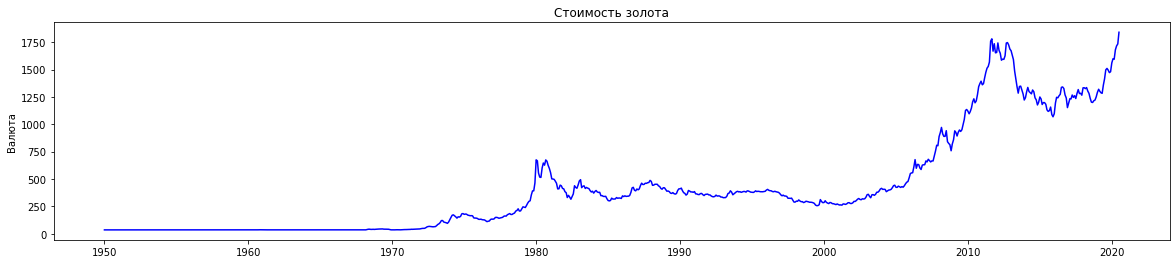

In [8]:
plt.figure(figsize =(20,4))
plt.plot( df.index, df['Price'], 'b' )
plt.title('Стоимость золота' )
plt.ylabel ( 'Валюта' )
plt.show()

До 1972 года ничего интересного не происходило, и золото торговалось по одной цене, есть смысл обрезать данные до цен на нефть равным 250

In [9]:
ind_start = np.where(df.loc[:,'Price'].values>250)[0]
ind_start[0]

352

In [10]:
df = df.iloc[ind_start[0]:,:]

In [11]:
df.head()

,Price
Date,
1979-05-01,257.738
1979-06-01,279.360
1979-07-01,295.009
1979-08-01,300.793
1979-09-01,354.498


In [12]:
df.shape

(495, 1)

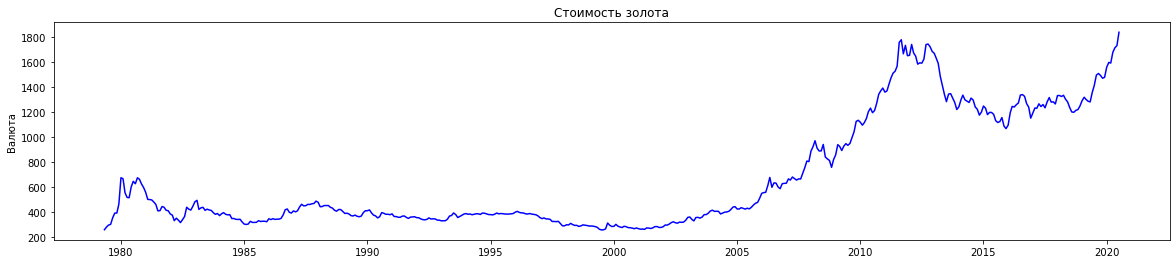

In [13]:
plt.figure(figsize =(20,4))
plt.plot(df.index, df['Price'], 'b' )
plt.title('Стоимость золота' )
plt.ylabel ( 'Валюта' )
plt.show()

Данные уже предоставлены по месяцам, и особого смысла ресемпл делать не нужно

In [14]:
df = df.resample('M').mean()

In [15]:
df.head()

,Price
Date,
1979-05-31,257.738
1979-06-30,279.360
1979-07-31,295.009
1979-08-31,300.793
1979-09-30,354.498


Создадим календарные фичи

In [16]:
df['date'] = df.index

In [17]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['dayofmonth'] = df['date'].dt.day
df['quarter'] = df['date'].dt.quarter
df['dayofyear'] = df['date'].dt.dayofyear
df['weekofyear'] = df['date'].dt.isocalendar().week
df['dayofweek'] = df['date'].dt.dayofweek

После генерации фич дата, как фича, нам больше не нужна 

In [18]:
df.drop(['date'], inplace = True, axis = 1)

Импортируем библиотеки

In [8]:
from sklearn.cluster import KMeans, DBSCAN, Birch
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE 

import seaborn as sns
import umap

Нормируем данные 

$$z = \frac{x - \mu}{std}$$

In [20]:
scl=StandardScaler()
Xscale = scl.fit_transform(df)

Список разных метрик для UMAP, выберу ту, которая лучше выглядит

Проверил много разных метрик, но решил остановится на простом манхетонском расстоянии 

Вместо t-sne я решил использовать umap, не забыв указать случайное зернышко. функция которая сохраняет картинки получившиеся после umap

Попробовал вместо DBSCAN  применить Birch, с n_clusters = 4, он дал результат лучше 

In [21]:
def umap_metrics(X , metrics, n = 15, n_clusters = 4):
    for metric in metrics:
        brc = Birch(n_clusters=n_clusters)
        dbscan = DBSCAN(eps=2, leaf_size=5)
        df = umap.UMAP(n_neighbors=n, metric=metric, random_state =42).fit_transform(X)
        X_brc =brc.fit_predict(df)
        X_dbs =dbscan.fit_predict(df)
        plt.figure(figsize = (16,9))
        ax = sns.scatterplot(x=df[:,0], y=df[:,1],  hue=X_brc)
        plt.title("Umap | metric -"+ metric +"  | n -"+ str(n))
        
    return X_brc, X_dbs

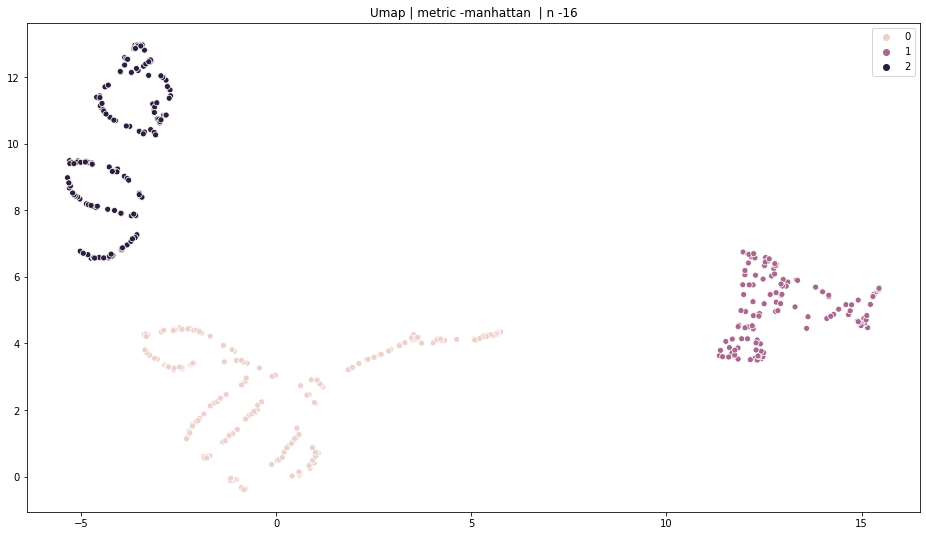

In [22]:
X_brc, X_dbs = umap_metrics(df, ['manhattan'], n = 16, n_clusters = 3)

In [24]:
print('Число кластеров DBSCAN в календаре с масштабированием: ',len(np.unique(X_dbs)))
print('Число кластеров BIRCH в календаре: ',len(np.unique(X_brc)))

Число кластеров DBSCAN в календаре с масштабированием:  3
Число кластеров BIRCH в календаре:  3


In [25]:
df['c_DBSCAN'] = X_dbs
df['c_BIRCH'] = X_brc

In [26]:
df.head()

,Price,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,c_DBSCAN,c_BIRCH
Date,,,,,,,,,,
1979-05-31,257.738,1979,5,31,2,151,22,3,0,0
1979-06-30,279.360,1979,6,30,2,181,26,5,0,0
1979-07-31,295.009,1979,7,31,3,212,31,1,1,2
1979-08-31,300.793,1979,8,31,3,243,35,4,1,2
1979-09-30,354.498,1979,9,30,3,273,39,6,1,2


Тут беру из методички 

Дополнительные фичи можно получить применив алгоритм PCA 

In [7]:
from sklearn.decomposition import PCA

In [28]:
pca = PCA(n_components=2, svd_solver='full')
Xpca=pca.fit_transform(Xscale[:,1:])
Xpca.shape

(495, 2)

In [29]:
df['pca1']=Xpca[:,0]
df['pca2']=Xpca[:,1]

Добавим новых признаков, описывающих содержание ряда. К таким признакам можно отнести разности ряда и разнообразные варианты сглаживания. Добавим к нашей модели 1-е разности. При этом следует помнить, что такие операции уменьшают общую длину корректной выборки на 1, т.е. первую строку данных следует исключить из модели в момент обучения.

In [30]:
first_diff =np.array(df.iloc[1:,0].values - df.iloc[:-1,0].values).astype('float32') 

In [31]:
df['diff1'] = 0.0
df['diff1'] =  df['diff1'].astype('float') 
df['diff1'].values[1:] = first_diff

In [32]:
df.head()

,Price,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,c_DBSCAN,c_BIRCH,pca1,pca2,diff1
Date,,,,,,,,,,,,,
1979-05-31,257.738,1979,5,31,2,151,22,3,0,0,-0.646576,0.523947,0.000000
1979-06-30,279.360,1979,6,30,2,181,26,5,0,0,-0.436225,-0.644128,21.622000
1979-07-31,295.009,1979,7,31,3,212,31,1,1,2,0.653447,1.442625,15.649000
1979-08-31,300.793,1979,8,31,3,243,35,4,1,2,1.083816,-0.003650,5.784000
1979-09-30,354.498,1979,9,30,3,273,39,6,1,2,1.294167,-1.171725,53.705002


Думаю, что стоит взять и вторую разность 

In [33]:
second_diff =np.array(df.iloc[2:,-1].values - df.iloc[:-2, -1].values).astype('float32') 

In [34]:

df['diff2'] = 0.0
df['diff2'] =  df['diff2'].astype('float') 
df['diff2'].values[2:] = second_diff

Вообще можно добавить все, что можем придумать. Например, логарифм признака, частные признаков , частные логарифмов и т.д. 

In [35]:
first_diff_d =(first_diff) / df.iloc[1:,0].values
df['diff1_d'] = 0.0
df['diff1_d'] =  df['diff1_d'].astype('float') 
df['diff1_d'].values[1:] = np.array(first_diff_d).astype('float32')

И для второй разности 

In [37]:
df.head()

,Price,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,c_DBSCAN,c_BIRCH,pca1,pca2,diff1,diff2,diff1_d
Date,,,,,,,,,,,,,,,
1979-05-31,257.738,1979,5,31,2,151,22,3,0,0,-0.646576,0.523947,0.000000,0.000000,0.000000
1979-06-30,279.360,1979,6,30,2,181,26,5,0,0,-0.436225,-0.644128,21.622000,0.000000,0.077398
1979-07-31,295.009,1979,7,31,3,212,31,1,1,2,0.653447,1.442625,15.649000,15.649000,0.053046
1979-08-31,300.793,1979,8,31,3,243,35,4,1,2,1.083816,-0.003650,5.784000,-15.837999,0.019229
1979-09-30,354.498,1979,9,30,3,273,39,6,1,2,1.294167,-1.171725,53.705002,38.056000,0.151496


In [39]:
second_diff_d =(second_diff) / df.iloc[2:,-3].values
df['diff2_d'] = 0.0
df['diff2_d'] =  df['diff2_d'].astype('float') 
df['diff2_d'].values[2:] = np.array(second_diff_d).astype('float32')

Добавим скользящее среднее по всей модели с глубиной 3 месяца. Размер окна определен длиной циклов осень, зима, весна, лето

и добавим скользящее среднее по всей модели с глубиной в 1 год 

In [40]:
df['d_m3']=df['Price'].rolling(window=3).mean()
df['d_m12'] = df['Price'].rolling(window=12).mean()

А теперь добавим еще и экспонентциальную среднюю. Медленную, т.к. интересная информация лежит на уровне сезонных колебаний цены.

Просто взял из методички

In [41]:
def exponential_smoothing(series, alpha):
    result = [series[0]] 
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [42]:
df['exp_0_05'] = exponential_smoothing(df['Price'], 0.05)
df['exp_0_03'] = exponential_smoothing(df['Price'], 0.03)
df['exp_0_08'] = exponential_smoothing(df['Price'], 0.08)

In [43]:
df.to_csv('gold_2.csv', index=True)

In [3]:
df = pd.read_csv('gold_2.csv', index_col=[0], parse_dates=[0])

In [44]:
df.head()

,Price,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,c_DBSCAN,c_BIRCH,...,pca2,diff1,diff2,diff1_d,diff2_d,d_m3,d_m12,exp_0_05,exp_0_03,exp_0_08
Date,,,,,,,,,,,,,,,,,,,,,
1979-05-31,257.738,1979,5,31,2,151,22,3,0,0,...,0.523947,0.000000,0.000000,0.000000,0.0,NaN,NaN,257.738000,257.738000,257.738000
1979-06-30,279.360,1979,6,30,2,181,26,5,0,0,...,-0.644128,21.622000,0.000000,0.077398,0.0,NaN,NaN,258.819100,258.386660,259.467760
1979-07-31,295.009,1979,7,31,3,212,31,1,1,2,...,1.442625,15.649000,15.649000,0.053046,1.0,277.369000,NaN,260.628595,259.485330,262.311059
1979-08-31,300.793,1979,8,31,3,243,35,4,1,2,...,-0.003650,5.784000,-15.837999,0.019229,1.0,291.720667,NaN,262.636815,260.724560,265.389614
1979-09-30,354.498,1979,9,30,3,273,39,6,1,2,...,-1.171725,53.705002,38.056000,0.151496,1.0,316.766667,NaN,267.229874,263.537763,272.518285


### В итоге данные примут вид

In [45]:
df.head()

,Price,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,c_DBSCAN,c_BIRCH,...,pca2,diff1,diff2,diff1_d,diff2_d,d_m3,d_m12,exp_0_05,exp_0_03,exp_0_08
Date,,,,,,,,,,,,,,,,,,,,,
1979-05-31,257.738,1979,5,31,2,151,22,3,0,0,...,0.523947,0.000000,0.000000,0.000000,0.0,NaN,NaN,257.738000,257.738000,257.738000
1979-06-30,279.360,1979,6,30,2,181,26,5,0,0,...,-0.644128,21.622000,0.000000,0.077398,0.0,NaN,NaN,258.819100,258.386660,259.467760
1979-07-31,295.009,1979,7,31,3,212,31,1,1,2,...,1.442625,15.649000,15.649000,0.053046,1.0,277.369000,NaN,260.628595,259.485330,262.311059
1979-08-31,300.793,1979,8,31,3,243,35,4,1,2,...,-0.003650,5.784000,-15.837999,0.019229,1.0,291.720667,NaN,262.636815,260.724560,265.389614
1979-09-30,354.498,1979,9,30,3,273,39,6,1,2,...,-1.171725,53.705002,38.056000,0.151496,1.0,316.766667,NaN,267.229874,263.537763,272.518285


Построим графики 

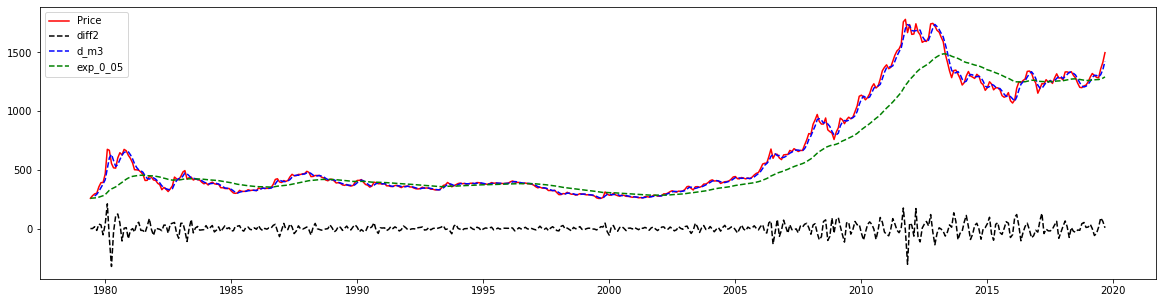

In [46]:
N100=484
plt.figure(figsize=(20,5))
plt.plot(df.index[:N100],df['Price'][:N100],'r',label ='Price')
plt.plot(df.index[:N100],df['diff2'][:N100],'--k',label ='diff2')
plt.plot(df.index[:N100],df['d_m3'][:N100],'--b',label ='d_m3')
plt.plot(df.index[:N100],df['exp_0_05'][:N100],'--g',label ='exp_0_05')
plt.legend()
plt.show()

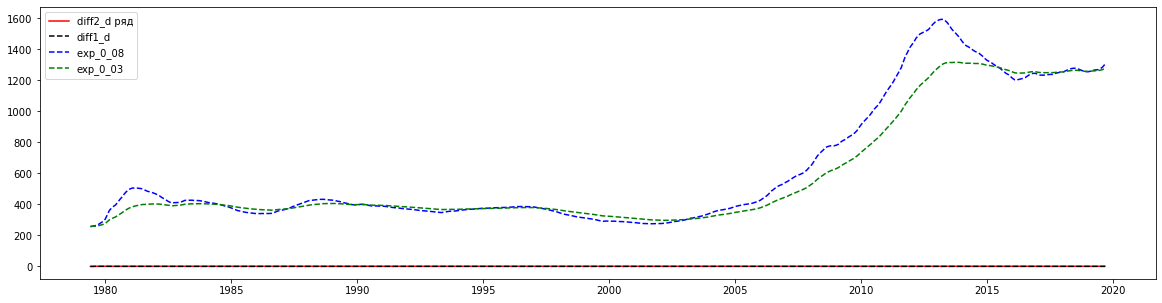

In [47]:
plt.figure(figsize=(20,5))
plt.plot(df.index[:N100],df['diff2_d'][:N100],'r',label ='diff2_d ряд')
plt.plot(df.index[:N100],df['diff1_d'][:N100],'--k',label ='diff1_d')
plt.plot(df.index[:N100],df['exp_0_08'][:N100],'--b',label ='exp_0_08 ')
plt.plot(df.index[:N100],df['exp_0_03'][:N100],'--g',label ='exp_0_03')
plt.legend()
plt.show()

Видны две аномалии в 1985 и 2008 году

### Думаю, что тут нет особого смысла применять Бокса Кокса, но еще подумаю 

Добавим истории длиной p в признаках автокорреляции

In [11]:
p = 14

In [48]:

for i in range(p):
    df['t'+str(p-i)]=0
    df['t'+str(p-i)].values[p:] = df['Price'].values[i:-(p)+i]

Аналогично добавляем первые разности на глубину p

In [49]:
p = 14
for i in range(p):
    df['d'+str(p-i)]=0
    df['d'+str(p-i)].values[p:] = df['diff1'].values[i:-(p)+i]

Итоговая система признаков

In [50]:
df.head(20)

,Price,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,c_DBSCAN,c_BIRCH,...,d10,d9,d8,d7,d6,d5,d4,d3,d2,d1
Date,,,,,,,,,,,,,,,,,,,,,
1979-05-31,257.738,1979,5,31,2,151,22,3,0,0,...,0,0,0,0,0,0,0,0,0,0
1979-06-30,279.360,1979,6,30,2,181,26,5,0,0,...,0,0,0,0,0,0,0,0,0,0
1979-07-31,295.009,1979,7,31,3,212,31,1,1,2,...,0,0,0,0,0,0,0,0,0,0
1979-08-31,300.793,1979,8,31,3,243,35,4,1,2,...,0,0,0,0,0,0,0,0,0,0
1979-09-30,354.498,1979,9,30,3,273,39,6,1,2,...,0,0,0,0,0,0,0,0,0,0
1979-10-31,390.959,1979,10,31,4,304,44,2,1,2,...,0,0,0,0,0,0,0,0,0,0
1979-11-30,391.518,1979,11,30,4,334,48,4,1,2,...,0,0,0,0,0,0,0,0,0,0
1979-12-31,463.666,1979,12,31,4,365,1,0,1,2,...,0,0,0,0,0,0,0,0,0,0
1980-01-31,674.580,1980,1,31,1,31,5,3,0,0,...,0,0,0,0,0,0,0,0,0,0


Отрежу первые 11 строк, для которых нет скользящего среднего

In [51]:
df = df.iloc[14:, :]

In [69]:
df.head()

,Price,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,c_DBSCAN,c_BIRCH,pca1,pca2,diff1,diff2,diff1_d,diff2_d,d_m3,d_m12,exp_0_05,exp_0_03,exp_0_08,t14,t13,t12,t11,t10,t9,t8,t7,t6,t5,t4,t3,t2,t1,d14,d13,d12,d11,d10,d9,d8,d7,d6,d5,d4,d3,d2,d1
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1980-07-31,645.750,1980,7,31,3,213,31,3,0,0,0.666070,0.474463,44.964001,47.406002,0.069631,1.0,586.934667,506.141417,380.808930,337.952262,432.401377,257,279,295,300,354,390,391,463,674,665,554,516,514,600,0,21,15,5,53,36,0,72,210,-8,-111,-37,-2,86
1980-08-31,626.360,1980,8,31,3,244,35,6,0,0,1.096439,-0.971812,-19.389999,-105.907997,-0.030957,1.0,624.298667,533.272000,393.086483,346.604494,447.918066,279,295,300,354,390,391,463,674,665,554,516,514,600,645,21,15,5,53,36,0,72,210,-8,-111,-37,-2,86,44
1980-09-30,673.941,1980,9,30,3,274,40,1,0,0,1.302019,1.171082,47.581001,2.617001,0.070601,1.0,648.683667,559.892250,407.129209,356.424589,465.999901,295,300,354,390,391,463,674,665,554,516,514,600,645,626,15,5,53,36,0,72,210,-8,-111,-37,-2,86,44,-19
1980-10-31,662.270,1980,10,31,4,305,44,4,0,0,2.396463,-0.053134,-11.671000,7.719000,-0.017623,1.0,654.190333,582.501500,419.886249,365.599951,481.701509,300,354,390,391,463,674,665,554,516,514,600,645,626,673,5,53,36,0,72,210,-8,-111,-37,-2,86,44,-19,47
1980-11-30,623.875,1980,11,30,4,335,48,6,0,0,2.606814,-1.221209,-38.395000,-85.975998,-0.061543,1.0,653.362000,601.864583,430.085686,373.348203,493.075388,354,390,391,463,674,665,554,516,514,600,645,626,673,662,53,36,0,72,210,-8,-111,-37,-2,86,44,-19,47,-11


In [54]:
df.to_csv('gold_3.csv', index=True)

In [4]:
df = pd.read_csv('gold_3.csv', index_col=[0], parse_dates=[0])

## Выделение существенных признаков

Запишем итоговую систему признаков и проведем ее анализ. Горизонт прогнозирования h = 1, тогда target = y(t+h)=y(t+1) 

In [5]:
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import SelectFromModel

from sklearn.ensemble import GradientBoostingRegressor

from sklearn.feature_selection import f_regression, mutual_info_regression

In [9]:
scl_target=StandardScaler() 

In [12]:
h = 1 
target_1 = df['Price'].values[h+p:].reshape((df.shape[0]-h-p,1))
y_1 = scl_target.fit_transform(target_1)
y_1.shape

(469, 1)

Входной набор признаков берем из нашей таблицы. Необходимо помнить, что у нас есть интегральные признаки (для календаря), которые связаны с базовыми признаками. Обычно такие признаки рассматривают отдельно. Однако для эксперимента оставим все признаки для процедуры селекции.

In [13]:
scl_x=StandardScaler() 

X_1 = df.iloc[p:-h,:].values
X_1 = scl_x.fit_transform(X_1.astype('float64'))
X_1.shape

(469, 49)

In [14]:
np.isnan(X_1).sum()

0

In [15]:
f_test, _ = f_regression(X_1, y_1.ravel())
f_test /= np.nanmax(f_test)
for i in range(X_1.shape[1]):
    print("F-test={:.2f},  I={}".format(f_test[i],i))

F-test=1.00,  I=0
F-test=0.01,  I=1
F-test=0.00,  I=2
F-test=0.00,  I=3
F-test=0.00,  I=4
F-test=0.00,  I=5
F-test=0.00,  I=6
F-test=0.00,  I=7
F-test=0.01,  I=8
F-test=0.00,  I=9
F-test=0.00,  I=10
F-test=0.00,  I=11
F-test=0.00,  I=12
F-test=0.00,  I=13
F-test=0.00,  I=14
F-test=nan,  I=15
F-test=0.53,  I=16
F-test=0.15,  I=17
F-test=0.05,  I=18
F-test=0.03,  I=19
F-test=0.09,  I=20
F-test=0.04,  I=21
F-test=0.04,  I=22
F-test=0.04,  I=23
F-test=0.05,  I=24
F-test=0.06,  I=25
F-test=0.06,  I=26
F-test=0.07,  I=27
F-test=0.08,  I=28
F-test=0.10,  I=29
F-test=0.12,  I=30
F-test=0.15,  I=31
F-test=0.19,  I=32
F-test=0.27,  I=33
F-test=0.42,  I=34
F-test=0.00,  I=35
F-test=0.00,  I=36
F-test=0.00,  I=37
F-test=0.00,  I=38
F-test=0.00,  I=39
F-test=0.00,  I=40
F-test=0.00,  I=41
F-test=0.00,  I=42
F-test=0.00,  I=43
F-test=0.00,  I=44
F-test=0.00,  I=45
F-test=0.00,  I=46
F-test=0.00,  I=47
F-test=0.00,  I=48


/home/egor/anaconda3/envs/py_3.8.5_j/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Проверка через F-test показывает, что есть корреляционная связь с предшествующим значением ряда (признак X[:,0]), а кроме этого интересные признаки от 14 и 34. Применим автоматизацию выбора через SelectKBest c выделением 5 лучших признаков.


In [16]:
sfk =SelectKBest(f_regression, k=6)
X_new1 =sfk.fit_transform(X_1, y_1.ravel())
X_new1.shape

/home/egor/anaconda3/envs/py_3.8.5_j/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


(469, 6)

In [17]:
column_names = df.columns[sfk.get_support()]
column_names

Index(['Price', 'd_m3', 't4', 't3', 't2', 't1'], dtype='object')

Как видим, были выбраны параметры, которые показывают корреляцию цен на золото со своими значениями в прошлом, плюс может быть угадал с циклом 

Лучшее множество признаков отделено в X_new1. Проверим результат оценки признаков по процентному отбору и сохраним его в X_new2.

In [18]:
sfp=SelectPercentile(f_regression, percentile=10)
X_new2 = sfp.fit_transform(X_1, y_1.ravel())
X_new2.shape

/home/egor/anaconda3/envs/py_3.8.5_j/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


(469, 5)

In [19]:
column_namesp = df.columns[sfp.get_support()]
column_namesp

Index(['Price', 'd_m3', 't3', 't2', 't1'], dtype='object')

Видим тот же результат

In [20]:
np.isinf(X_1).sum()

0

In [21]:
gr_model = GradientBoostingRegressor(max_depth=5, random_state=40, n_estimators=100).fit(X_1, y_1.ravel())
sfm = SelectFromModel(gr_model,  max_features = 5)

sfm.fit(X_1, y_1.ravel())
X_new3 = sfm.transform(X_1)
X_new3.shape

(469, 2)

In [22]:
list_param_k =np.where(sfk.get_support())[0]
list_param_p =np.where(sfp.get_support())[0]
list_param_m =np.where(sfm.get_support())[0]

print('Номера признаков k лучших признаков : ',list_param_k)
print('Номера признаков лучших признаков по процентной форме: ',list_param_p)
print('Номера признаков для выбора по модели : ',list_param_m)

Номера признаков k лучших признаков :  [ 0 16 31 32 33 34]
Номера признаков лучших признаков по процентной форме:  [ 0 16 32 33 34]
Номера признаков для выбора по модели :  [ 0 16]


In [23]:
list_par=[16, 31 , 32 , 33 , 34]
X_new = X_1[:,list_par]
df.columns[list_par]

Index(['d_m3', 't4', 't3', 't2', 't1'], dtype='object')

## Разделение данных на тестовые и тренировочные 

Построение модели начинаем с выделения тестовой части нашего ряда. Напомним, что для временных рядов тест - непрерывная часть ряда не входившая в обучение (временные ряды 1). Будем отделять по индексу, который задаст дату разделения модели на тест и обучение.

In [24]:
# сделаем функцию
def split_data( data, split_date ):
    return data.loc[data.index.get_level_values('Date') <= split_date].copy(), \
           data.loc[data.index.get_level_values('Date') >  split_date].copy()

In [25]:
train, test = split_data( df, '06-2016')

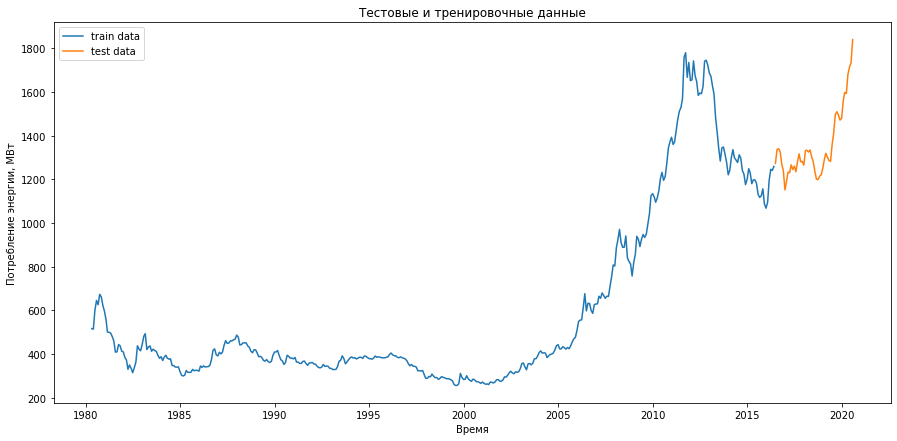

In [26]:
plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(train.index, train['Price'], label='train data' )
plt.plot(test.index ,test['Price'], label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()

In [27]:
X_train =X_new[:train.shape[0],:]
y_train =y_1[:train.shape[0],0]
X_test =X_new[train.shape[0]:,:]
y_test =y_1[train.shape[0]:,0]

# Строим Модель

SARIMAX и ARIMA были использованы в прошлой работе. Попробую GradientBoostingRegressor

In [28]:
from sklearn.ensemble import GradientBoostingRegressor

Все модели возьмем в варианте параметров по умолчанию, кроме глубины деревьев.

In [29]:
model_g = GradientBoostingRegressor(max_depth=5, random_state=42, n_estimators=100)

In [30]:
model_g.fit( X_train, y_train )

GradientBoostingRegressor(max_depth=5, random_state=42)

In [31]:
y_test_pred_g = model_g.predict(X_test)

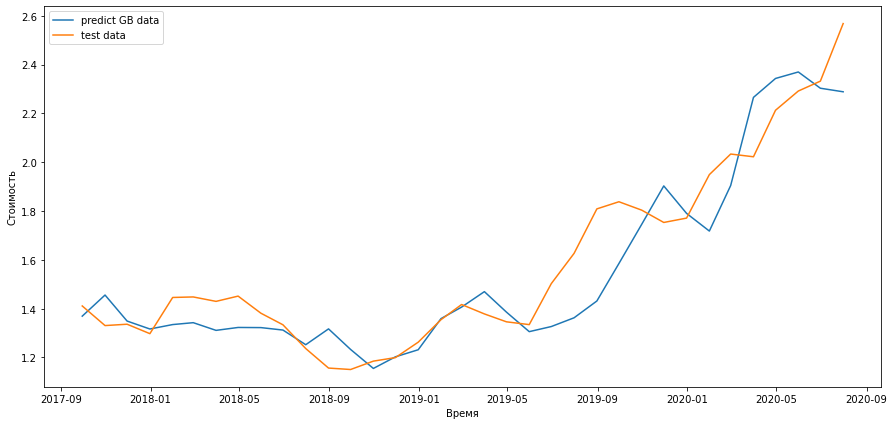

In [32]:
plt.figure( figsize=( 15, 7 ))


plt.xlabel('Время')
plt.ylabel('Стоимость')
plt.plot(test.index[h+p:],y_test_pred_g, label='predict GB data' )
plt.plot(test.index[h+p:],y_test, label='test data')

plt.legend()
plt.show()

In [33]:
class Model():
    
    def __init__(self, df , h = 3 , p = 14, k = 6, percentile = 10, g_max_depth = 5, g_n_estimators = 100):
        self.df = df 
        self.h = h
        self.p = p
        self.k = k
        self.y, self.scl_target = self.scale_scl_y()
        self.X, self.scl_x = self.scale_scl_x()
        self.f = self.f_test()
        self.sfk, self.X_new = self.select_k_best()
        self.percentile = percentile
        self.sfp, self.X_new2 = self.select_p()
        self.g_max_depth = g_max_depth
        self.g_n_estimators = g_n_estimators
        self.sfm, self.X_new3 = self.gr_model_estimator()
        self.X_n = self.print_params()
    
    def scale_scl_y(self):
        scl_target = StandardScaler()
        target_1 = self.df['Price'].values[self.h+self.p:].reshape((self.df.shape[0]-self.h-self.p,1))
        y = scl_target.fit_transform(target_1)
        print(f'y shape after noramalize - {y.shape}')
        return y, scl_target
    
    def scale_scl_x(self):
        scl_x=StandardScaler() 
        X = self.df.iloc[self.p:-self.h,:].values
        X = scl_x.fit_transform(X.astype('float64'))
        print(f'X shape after normalize - {X.shape}')
        return X, scl_x
    
    def f_test(self):
        f_test, _ = f_regression(self.X, self.y.ravel())
        f_test /= np.nanmax(f_test)
        print(f'Значения F-test')
        for i in range(self.X.shape[1]):
            print("F-test={:.2f},  I={}".format(f_test[i],i))
    
    
    def select_k_best(self):
        sfk =SelectKBest(f_regression, k = self.k)
        X_new =sfk.fit_transform(self.X, self.y.ravel())
        print(f'SelectKBest  shape - {X_new.shape}')
        return sfk, X_new
    
    def select_p(self):
        sfp=SelectPercentile(f_regression, percentile=self.percentile)
        X_new2 = sfp.fit_transform(self.X, self.y.ravel())
        print(f'SelectKBest  shape - {X_new2.shape}')
        return sfp, X_new2
        
    def gr_model_estimator(self):
        gr_model = GradientBoostingRegressor(max_depth=self.g_max_depth, random_state=40, n_estimators = self.g_n_estimators).fit(self.X, self.y.ravel())
        sfm = SelectFromModel(gr_model,  max_features = self.k)
        sfm.fit(self.X, self.y.ravel())
        X_new3 = sfm.transform(self.X)
        print(f'GradientBoostingRegressor - {X_new3.shape}')
        return sfm, X_new3
        
    def print_params(self):
        list_param_k =np.where(self.sfk.get_support())[0]
        list_param_p =np.where(self.sfp.get_support())[0]
        list_param_m =np.where(self.sfm.get_support())[0]

        print('Номера признаков k лучших признаков : ',list_param_k)
        print('Номера признаков лучших признаков по процентной форме: ',list_param_p)
        print('Номера признаков для выбора по модели : ',list_param_m)
        columns = np.intersect1d(list_param_k , list_param_p)
        columns = np.unique(np.concatenate((columns, list_param_m[1:]), 0))
        #print(f'Фичи - {columns} \n Хотите дополнить список?')
        #c = int(input())
        print(f'Самые важные фичи - {columns}')
        X_n = self.X[:,columns]
        return X_n
       
    
        

In [34]:
m_1 = Model(df, h = 1, p = 14)

y shape after noramalize - (469, 1)
X shape after normalize - (469, 49)
Значения F-test
F-test=1.00,  I=0
F-test=0.01,  I=1
F-test=0.00,  I=2
F-test=0.00,  I=3
F-test=0.00,  I=4
F-test=0.00,  I=5
F-test=0.00,  I=6
F-test=0.00,  I=7
F-test=0.01,  I=8
F-test=0.00,  I=9
F-test=0.00,  I=10
F-test=0.00,  I=11
F-test=0.00,  I=12
F-test=0.00,  I=13
F-test=0.00,  I=14
F-test=nan,  I=15
F-test=0.53,  I=16
F-test=0.15,  I=17
F-test=0.05,  I=18
F-test=0.03,  I=19
F-test=0.09,  I=20
F-test=0.04,  I=21
F-test=0.04,  I=22
F-test=0.04,  I=23
F-test=0.05,  I=24
F-test=0.06,  I=25
F-test=0.06,  I=26
F-test=0.07,  I=27
F-test=0.08,  I=28
F-test=0.10,  I=29
F-test=0.12,  I=30
F-test=0.15,  I=31
F-test=0.19,  I=32
F-test=0.27,  I=33
F-test=0.42,  I=34
F-test=0.00,  I=35
F-test=0.00,  I=36
F-test=0.00,  I=37
F-test=0.00,  I=38
F-test=0.00,  I=39
F-test=0.00,  I=40
F-test=0.00,  I=41
F-test=0.00,  I=42
F-test=0.00,  I=43
F-test=0.00,  I=44
F-test=0.00,  I=45
F-test=0.00,  I=46
F-test=0.00,  I=47
F-test=0.00

/home/egor/anaconda3/envs/py_3.8.5_j/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/home/egor/anaconda3/envs/py_3.8.5_j/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/home/egor/anaconda3/envs/py_3.8.5_j/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


GradientBoostingRegressor - (469, 2)
Номера признаков k лучших признаков :  [ 0 16 31 32 33 34]
Номера признаков лучших признаков по процентной форме:  [ 0 16 32 33 34]
Номера признаков для выбора по модели :  [ 0 16]
Самые важные фичи - [ 0 16 32 33 34]


In [35]:
m_3 = Model(df, h = 3, p = 14)

y shape after noramalize - (467, 1)
X shape after normalize - (467, 49)
Значения F-test
F-test=1.00,  I=0
F-test=0.03,  I=1
F-test=0.00,  I=2
F-test=0.00,  I=3
F-test=0.00,  I=4
F-test=0.00,  I=5
F-test=0.00,  I=6
F-test=0.00,  I=7
F-test=0.02,  I=8
F-test=0.00,  I=9
F-test=0.00,  I=10
F-test=0.00,  I=11
F-test=0.00,  I=12
F-test=0.00,  I=13
F-test=0.00,  I=14
F-test=nan,  I=15
F-test=0.80,  I=16
F-test=0.37,  I=17
F-test=0.16,  I=18
F-test=0.10,  I=19
F-test=0.24,  I=20
F-test=0.12,  I=21
F-test=0.13,  I=22
F-test=0.14,  I=23
F-test=0.15,  I=24
F-test=0.17,  I=25
F-test=0.19,  I=26
F-test=0.21,  I=27
F-test=0.24,  I=28
F-test=0.27,  I=29
F-test=0.31,  I=30
F-test=0.37,  I=31
F-test=0.45,  I=32
F-test=0.57,  I=33
F-test=0.72,  I=34
F-test=0.00,  I=35
F-test=0.00,  I=36
F-test=0.00,  I=37
F-test=0.00,  I=38
F-test=0.00,  I=39
F-test=0.00,  I=40
F-test=0.00,  I=41
F-test=0.00,  I=42
F-test=0.00,  I=43
F-test=0.00,  I=44
F-test=0.00,  I=45
F-test=0.00,  I=46
F-test=0.00,  I=47
F-test=0.00

/home/egor/anaconda3/envs/py_3.8.5_j/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/home/egor/anaconda3/envs/py_3.8.5_j/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/home/egor/anaconda3/envs/py_3.8.5_j/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


GradientBoostingRegressor - (467, 6)
Номера признаков k лучших признаков :  [ 0 16 31 32 33 34]
Номера признаков лучших признаков по процентной форме:  [ 0 16 32 33 34]
Номера признаков для выбора по модели :  [ 0 16 17 19 20 34]
Самые важные фичи - [ 0 16 17 19 20 32 33 34]


In [36]:
class Split_data():
    
    def __init__(self, df, X, y, split_date  = '06-2018'):
        self.X = X 
        self.df = df
        self.y = y
        self.split_date = split_date
        self.train_index, self.test_index = self.split_data()
        self.X_train, self.y_train, self.X_test, self.y_test = self.X_y_train_test()
        
    def split_data(self):
        return self.df.loc[self.df.index <= self.split_date].copy(), \
               self.df.loc[self.df.index >  self.split_date].copy()
    
    def X_y_train_test(self):
        return  self.X[:self.train_index.shape[0],:], \
                self.y[:self.train_index.shape[0],0], \
                self.X[self.train_index.shape[0]:,:], \
                self.y[self.train_index.shape[0]:,0]

In [37]:
r_1 = Split_data(df, m_1.X_n, m_1.y, split_date = '2016-10')

In [38]:
r_3 = Split_data(df, m_3.X_n, m_3.y, split_date = '2016-10')

In [39]:
r_3.X_train.shape[0]

438

In [40]:
r_3.y_test.shape[0]

29

In [41]:
model_g_1 = GradientBoostingRegressor(max_depth=5, random_state=42, n_estimators=100)

In [42]:
model_g_3 = GradientBoostingRegressor(max_depth=5, random_state=42, n_estimators=100)

In [43]:
model_g_1.fit( r_1.X_train, r_1.y_train )

GradientBoostingRegressor(max_depth=5, random_state=42)

In [44]:
model_g_3.fit( r_3.X_train, r_3.y_train )

GradientBoostingRegressor(max_depth=5, random_state=42)

In [45]:
y_test_pred_g_1 = model_g_1.predict(r_1.X_test)

In [46]:
y_test_pred_g_3 = model_g_3.predict(r_3.X_test)

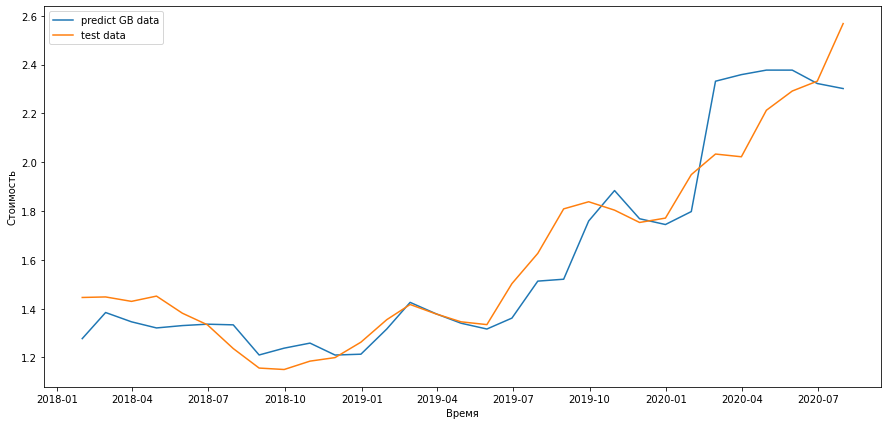

In [47]:
plt.figure( figsize=( 15, 7 ))


plt.xlabel('Время')
plt.ylabel('Стоимость')
plt.plot(r_1.test_index.index[m_1.h+m_1.p:],y_test_pred_g_1, label='predict GB data' )
plt.plot(r_1.test_index.index[m_1.h+m_1.p:],r_1.y_test, label='test data')

plt.legend()
plt.show()

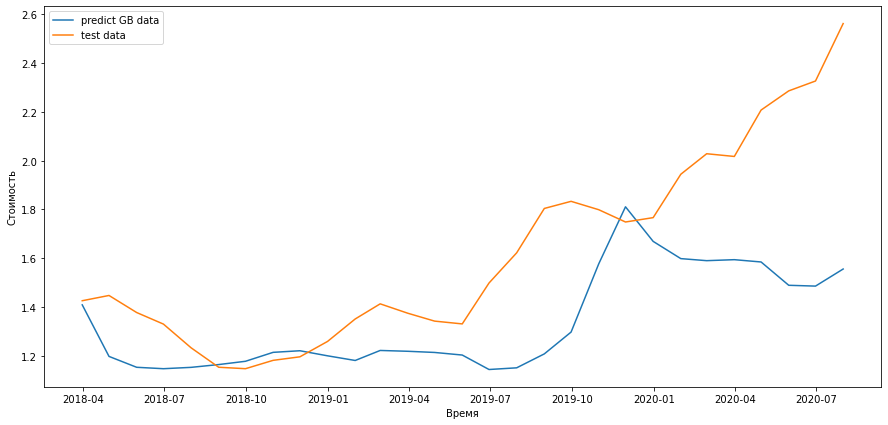

In [48]:
plt.figure( figsize=( 15, 7 ))


plt.xlabel('Время')
plt.ylabel('Стоимость')
plt.plot(r_3.test_index.index[m_3.h+m_3.p:],y_test_pred_g_3, label='predict GB data' )
plt.plot(r_3.test_index.index[m_3.h+m_3.p:],r_3.y_test, label='test data')

plt.legend()
plt.show()

## Оценки для сравнения моделей c h = 3 

In [49]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [50]:
class Error_count():

    def __init__(self, y_true, y_test_pred_g, scl_target):
        self.y_true = y_true
        self.scl_target = scl_target
        self.y_test_pred_g = y_test_pred_g
        self.er_s, self.er_a, self.er_r2 = self.error_c()
        self.er_g = self.mean_absolute_percentage_error()
        
        
    def error_c(self):
        er_s = mean_squared_error(y_true=self.y_true, y_pred=self.y_test_pred_g) 
        er_a = mean_absolute_error(y_true=self.y_true, y_pred=self.y_test_pred_g) 
        er_r2 = r2_score(y_true=self.y_true, y_pred=self.y_test_pred_g)

        print('ошибка mse :  ', er_s,'\nошибка mae  :  ', er_a,'\nоценка R2 :  ', er_r2)
           
        return er_s, er_a, er_r2
    
    def mean_absolute_percentage_error(self): 
        y_true, y_pred = np.array(self.scl_target.inverse_transform(self.y_true)), np.array(self.y_test_pred_g)
        mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
        print('#TODO тут явно ошибка вычисления')
        print(f'ошибка градиентного бустинга MAPE : {mape} %')
        return mape
    
 

In [51]:
e_1 = Error_count(r_1.y_test, y_test_pred_g_1, m_1.scl_target)

ошибка mse :   0.017705142222103797 
ошибка mae  :   0.09673288651827673 
оценка R2 :   0.8775835893330286
#TODO тут явно ошибка вычисления
ошибка градиентного бустинга MAPE : 99.88780914425148 %


In [52]:
e_3 = Error_count(r_3.y_test, y_test_pred_g_3, m_3.scl_target)

ошибка mse :   0.157595622323849 
ошибка mae  :   0.29315405930350236 
оценка R2 :   -0.03591068159439925
#TODO тут явно ошибка вычисления
ошибка градиентного бустинга MAPE : 99.90519605345189 %


## ВЫВОД 

К сожелению у меня не получилось посчитать MAPE, но по графикам видно, что в предсказание на три точки вперед модель справляется значительно хуже чем на один шаг вперед. Так же оценка R2 сильно упала по сравнению с одним шагом 

## Задача 4 

Примените авторекурсию и сравните результат в 4-й точке путем прямого моделирования и путем рекурсивного моделирования на длине выборки из 4-х точек. 

In [62]:
X_test_100 = r_3.X_test.copy()
y_test_100 = r_3.y_test.copy()

N10 = 100

for i in range(m_3.p,N10+m_3.p):
    
    y_test_100[i] = model_g_3.predict(X_test_100[i,:].reshape((1,X_test_100.shape[1])))
    
    # восстанавливаем не масштабированное значение ряда текущей точке  
    y_i= m_3.scl_target.inverse_transform(y_test_100[i:i+1]  )
                                     
    # заполняем вектор для прогноза следующей точки
    X_test_100[i+1,0] = (y_i-m_3.scl_x.mean_[0])/m_3.scl_x.scale_[0]
    
    # dm_3
    X_test_100[i+1,1] = np.mean(X_test_100[i-3:i+1,0]) 
    
    #dm_12
    X_test_100[i+1,2] = np.mean(X_test_100[i-12:i+1,0]) 
    
    #'exp_0_03' 
    X_test_100[i+1,3] = X_test_100[i,0]*(1-0.03)+ 0.07 * X_test_100[i+1,0] 
    
    
    #строим 'exp_0_05', 
    #X_test_100[i+1,3] = X_test_100[i,0]*(1-0.05)+ 0.08 * X_test_100[i+1,0]
    
    #'exp_0_08' 
    X_test_100[i+1,4] = X_test_100[i,0]*(1-0.08)+ 0.07 * X_test_100[i+1,0]
    
    # обновим историю значенний t
    X_test_100[i+1,5] = X_test_100[i-3,0]
    
    #t2
    X_test_100[i+1,6] = X_test_100[i-2,0]
    
    #t1
    X_test_100[i+1,7] = X_test_100[i-1,0]

In [61]:
df.iloc[:, 34].name

't1'

Построим график

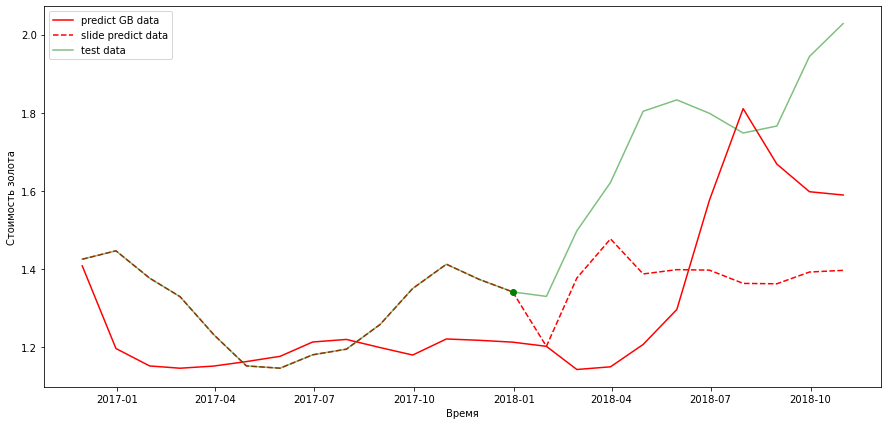

In [63]:
N10 = N10+m_3.p

plt.figure( figsize=( 15, 7 ))

plt.xlabel('Время')
plt.ylabel('Стоимость золота')
plt.plot(r_3.test_index.index[1:N10+1],y_test_pred_g_3[:N10], 'r',label='predict GB data' )
plt.plot(r_3.test_index.index[1:N10+1],y_test_100[:N10], '--r',label='slide predict data')
plt.plot(r_3.test_index.index[1:N10+1],r_3.y_test[:N10], 'g',label='test data', alpha=0.5)
plt.plot(r_3.test_index.index[m_3.p],r_3.y_test[m_3.p-1], 'og', alpha=1)
plt.legend()
plt.show()    